In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
import transformers as ppb
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
import collections as col
warnings.filterwarnings('ignore')

In [2]:
def clean_text(text):
    text = text.lower()
    
    # Remove stop words
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    return text

#### Import data

In [3]:
# Import csv
df = pd.read_csv('Combined_News_DJIA.csv')

### Preprocessing

In [4]:
# Combine headlines and remove other columns, keep only date and combined_headlines
df['combined_headlines'] = df[['Top1']].apply(lambda row:'.'.join(row.values.astype(str)), axis=1)
df = df[['combined_headlines', 'Label']]

# Remove unwanted characters
df.replace("[^a-zA-Z]"," ",regex=True, inplace=True)
df.replace("^b ","",regex=True, inplace=True)

# Remove stop words and convert to lower case
df['combined_headlines'] = df['combined_headlines'].apply(clean_text)

# Split dataset into train and test: 80% and 20%
# train = df.iloc[:1591, :]
# test = df.iloc[1591:, :]
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

# Transform combined headlines into a list for CountVectorizer input
train_headlines = train['combined_headlines'].tolist()

# Vectorize the data
vectorizer = CountVectorizer()
vectorized_train_headlines = vectorizer.fit_transform(train_headlines)

### EDA

#### Mean length of news description

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

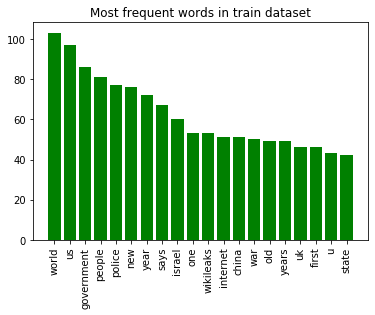

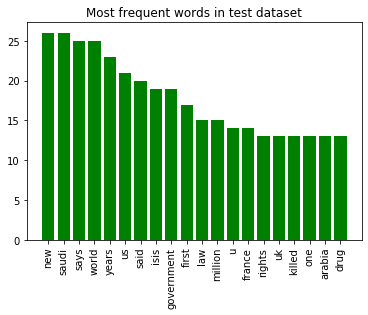

In [6]:
testheadlines = test['combined_headlines'].tolist()

tokens_all = []
for headlines in train_headlines:
    tokens = nltk.word_tokenize(headlines)
    tokens_all += tokens
    
counter_train = col.Counter(tokens_all)

tokens_all = []
for headlines in testheadlines:
    tokens = nltk.word_tokenize(headlines)
    tokens_all += tokens
    
counter_test = col.Counter(tokens_all)

c_train = np.array(counter_train.most_common(20))
c_test = np.array(counter_test.most_common(20))

plt.xticks(rotation = 90) 
plt.bar(c_train[:, 0], c_train[:, 1].astype('int'), color='green')
plt.title("Most frequent words in train dataset")
plt.savefig('most_freq_train.png')
plt.show()
plt.xticks(rotation = 90) 
plt.bar(c_test[:, 0], c_test[:, 1].astype('int'), color='green')
plt.title("Most frequent words in test dataset")
plt.savefig('most_freq_test.png')
plt.show()

### Logistic Regression

#### Hyperparameter tuning for C parameter

In [7]:
logreg_parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search_logreg = GridSearchCV(LogisticRegression(), logreg_parameters)
grid_search_logreg.fit(vectorized_train_headlines, train['Label'])

print('best parameters: ', grid_search_logreg.best_params_)
print('best scores: ', grid_search_logreg.best_score_)

best parameters:  {'C': 0.0001}
best scores:  0.5424262139942035


In [8]:
# Logistic Regression
# Fit for train set
logistic_reg = LogisticRegression(C=0.1)
logistic_reg = logistic_reg.fit(vectorized_train_headlines, train['Label'])

Text(0.5, 1, 'Accuracy Score: 0.5402010050251256')

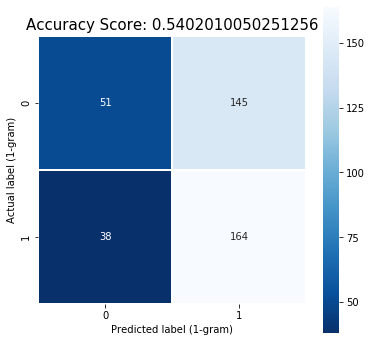

In [9]:
# Predict for test data
# test_headlines = combine_headlines(test)
test_headlines = test['combined_headlines'].tolist()
test_vectorized_headlines = vectorizer.transform(test_headlines)
prediction_labels = logistic_reg.predict(test_vectorized_headlines)
cm = metrics.confusion_matrix(test['Label'], prediction_labels)

# Use score method to get accuracy of model
score = logistic_reg.score(test_vectorized_headlines, test['Label'])

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label (1-gram)');
plt.xlabel('Predicted label (1-gram)');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

#### Implement 2-gram in bag of words while tokenization and model Logistic regression

In [10]:
# Fit model
ngram_vectorizer = CountVectorizer(ngram_range=(2,2))
ngram_train = ngram_vectorizer.fit_transform(train_headlines)

ngram_model = LogisticRegression(C=1)
ngram_model = ngram_model.fit(ngram_train, train['Label'])


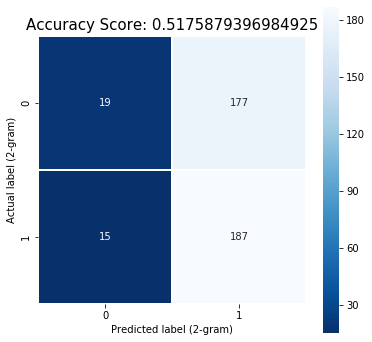

In [11]:
# Predict for test data
test_headlines = test['combined_headlines'].tolist()
ngram_test_vectorized_headlines = ngram_vectorizer.transform(test_headlines)
ngram_prediction_labels = ngram_model.predict(ngram_test_vectorized_headlines)
ngram_cm = metrics.confusion_matrix(test['Label'], ngram_prediction_labels)

# Use score method to get accuracy of model
ngram_score = ngram_model.score(ngram_test_vectorized_headlines, test['Label'])

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(ngram_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label (2-gram)');
plt.xlabel('Predicted label (2-gram)');
all_sample_title = 'Accuracy Score: {0}'.format(ngram_score)
plt.title(all_sample_title, size = 15);

#### Feature Extraction using tf-idf and then Logistic Regression

In [12]:
def to_words(content):
    letters_only = re.sub("[^a-zA-Z]", " ", content) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [13]:
tfidf_df = pd.read_csv('Combined_News_DJIA.csv')

tfidf_df['Combined']=tfidf_df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

train,test = train_test_split(tfidf_df,test_size=0.2,random_state=42)



In [14]:
# Use tfidf vectorizer
tfidf=TfidfVectorizer()
train_text = []
test_text = []
for each in train['Combined']:
    train_text.append(to_words(each))
for each in test['Combined']:
    test_text.append(to_words(each))
train_features = tfidf.fit_transform(train_text)
test_features = tfidf.transform(test_text)

Accuracy of LogisticRegression is 0.5703517587939698


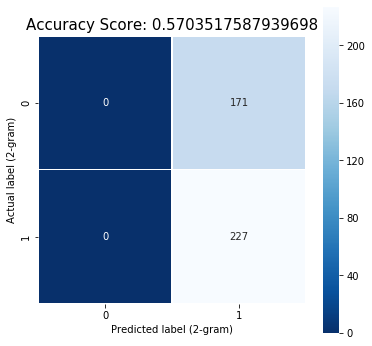

In [15]:
# Fit and predict using tfidf vectorized inputs and logistic regression classifier
tfidf_log_reg_classifier = LogisticRegression(C=0.1,solver='liblinear',max_iter=200)

fit = tfidf_log_reg_classifier.fit(train_features,train['Label'])
pred = fit.predict(test_features)
prob = fit.predict_proba(test_features)[:,1]

accuracy = accuracy_score(pred,test['Label'])
# Model.append(tfidf_log_reg_classifier.__class__.__name__)
print('Accuracy of '+tfidf_log_reg_classifier.__class__.__name__+' is '+str(accuracy))

tfidf_cm = metrics.confusion_matrix(test['Label'], pred)

# Use score method to get accuracy of model
tfidf_score = tfidf_log_reg_classifier.score(test_features, test['Label'])

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(tfidf_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label (2-gram)');
plt.xlabel('Predicted label (2-gram)');
all_sample_title = 'Accuracy Score: {0}'.format(tfidf_score)
plt.title(all_sample_title, size = 15);

### BERT

#### Importing the dataset

In [16]:
# Import dataset again to keep logistic regression and BERT independent of each other
bert_df = pd.read_csv('Combined_News_DJIA.csv')

#### Preparing dataset

In [17]:
def clean_text(text):
    
    text = text.lower()
    
    # Remove stop words
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    return text

In [18]:
# Combine headlines and remove other columns, keep only date and combined_headlines
bert_df['combined_headlines'] = bert_df[['Top1']].apply(lambda row:'.'.join(row.values.astype(str)), axis=1)
bert_df = bert_df[['combined_headlines', 'Label']]

bert_df.replace("[^a-zA-Z]"," ",regex=True, inplace=True)
bert_df.replace("^b ","",regex=True, inplace=True)

bert_df['combined_headlines'] = bert_df['combined_headlines'].apply(clean_text)

In [19]:
# Download stopwords if not available already
# nltk.download('stopwords')

# Using a different preprocessing step above which removes stop words 
# in addition to whatever this module does

# Combine headlines and remove other columns, keep only date and combined_headlines
# bert_df['combined_headlines'] = bert_df[['Top1']].apply(lambda row:'.'.join(row.values.astype(str)), axis=1)
# bert_df = bert_df[['combined_headlines', 'Label']]

# bert_df.replace("[^a-zA-Z]"," ",regex=True, inplace=True)
# bert_df.replace("^b ","",regex=True, inplace=True)

# for i in bert_df.columns:
#     if i=='Label':
#         continue
#     bert_df[i] = bert_df[i].lower()

#### Loading the Pre-trained BERT model

In [20]:
# DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# load pre-trained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

#### Tokenization

In [21]:
# Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with
tokenized = bert_df['combined_headlines'].apply((
    lambda x: tokenizer.encode(x, add_special_tokens=True)))

#### Padding

In [22]:
# After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). 
# It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths)
max_len = 0
for i in tokenized.values:
    if len(i)>max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

#### Masking

In [23]:
# If we directly send padded to BERT, that would slightly confuse it. 
# We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:
attention_mask = np.where(padded != 0, 1, 0)

#### Model 1: Deep Learning

In [24]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

#### Save features in a variable to be used in logistic regression later. Store labels in a separate variable as well (taken from original dataframe) 

In [25]:
features = last_hidden_states[0][:, 0, :].numpy()
labels = bert_df['Label']

#### Model 2: Logistic Regression. Hyperparameter tuning (grid search) for C parameter (regularization strength)

In [26]:
# Split into training and test set
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [27]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

best parameters:  {'C': 0.0001}
best scores:  0.5217974905164866


#### Fitting and Evaluating Model 2

In [28]:
lr_clf = LogisticRegression(C=0.0001)
lr_clf.fit(train_features, train_labels)

print(f'Accuracy score of BERT model: {lr_clf.score(test_features, test_labels)}')

# pred = lr_clf.predict(test_features)
# prob = lr_clf.predict_proba(test_features)[:,1]

# accuracy = accuracy_score(pred,test['Label'])
# Accuracy.append(accuracy)
# Model.append(tfidf_log_reg_classifier.__class__.__name__)
# print('Accuracy of '+tfidf_log_reg_classifier.__class__.__name__+' is '+str(accuracy))

# tfidf_cm = metrics.confusion_matrix(test['Label'], pred)

# # Use score method to get accuracy of model
# tfidf_score = tfidf_log_reg_classifier.score(test_features, test['Label'])

# # Plot confusion matrix
# plt.figure(figsize=(6,6))
# sns.heatmap(tfidf_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label (2-gram)');
# plt.xlabel('Predicted label (2-gram)');
# all_sample_title = 'Accuracy Score: {0}'.format(tfidf_score)
# plt.title(all_sample_title, size = 15);

Accuracy score of BERT model: 0.5763052208835341


### SVM

In [35]:
# This script concatenates all news headlines of a day into one and uses the tf-idf scheme to extract a feature vector.
# An SVM with rbf kernel without optimization of hyperparameters is used as a classifier.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from datetime import date

# read data
data = pandas.read_csv("Combined_News_DJIA.csv", )

# concatenate all news into one
data["combined_news"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

# convert to feature vector
feature_extraction = TfidfVectorizer()
X = feature_extraction.fit_transform(data["combined_news"].values)

# split into training- and test set
TRAINING_END = date(2014,12,31)
num_training = len(data[pandas.to_datetime(data["Date"]) <= TRAINING_END])
X_train = X[:num_training]
X_test = X[num_training:]
y_train = data["Label"].values[:num_training]
y_test = data["Label"].values[num_training:]

# train classifier
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train, y_train)

# predict and evaluate predictions
predictions = clf.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[  0 186]
 [  0 192]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378

